In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [5]:
df = pd.read_csv('../finaldata.csv', sep=',').set_index('Date')


In [6]:
b=df

In [7]:
b

,T2M,QV2M,PRECTOTCORR,WS10M,Hour_sin,Hour_cos,Day_sin,Day_cos
Date,,,,,,,,
2005-01-02 00:00:00,12.12,5.68,0.0,1.14,0.000000,1.000000,0.034422,0.999407
2005-01-02 01:00:00,11.80,5.62,0.0,1.26,0.258819,0.965926,0.034422,0.999407
2005-01-02 02:00:00,11.32,5.55,0.0,1.40,0.500000,0.866025,0.034422,0.999407
2005-01-02 03:00:00,11.03,5.43,0.0,1.53,0.707107,0.707107,0.034422,0.999407
2005-01-02 04:00:00,10.92,5.31,0.0,1.65,0.866025,0.500000,0.034422,0.999407
...,...,...,...,...,...,...,...,...
2022-11-15 01:00:00,12.45,7.45,0.0,0.76,0.258819,0.965926,0.255353,0.966848
2022-11-15 02:00:00,12.25,7.32,0.0,0.96,0.500000,0.866025,0.255353,0.966848
2022-11-15 03:00:00,11.83,7.20,0.0,1.06,0.707107,0.707107,0.255353,0.966848


In [8]:
n_steps_out=20
n_steps_in= 24
n_features = 8

In [9]:
# split a multivariate sequence into samples
def split_sequences(df, n_steps_in, n_steps_out):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)):
 # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
 # check if we are beyond the dataset
         if out_end_ix > len(df_as_np):
             break
 # gather input and output parts of the pattern
         seq_x, seq_y = df_as_np[i:end_ix, :], df_as_np[end_ix:out_end_ix, :2]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
X, y = split_sequences(b, n_steps_out=20,
n_steps_in= 24)
X.shape, y.shape

((156587, 24, 8), (156587, 20, 2))

In [11]:
print(f'Given X = {X[0].flatten()} \n')
print(f'we predict {y[0].flatten()}')

Given X = [ 1.21200000e+01  5.68000000e+00  0.00000000e+00  1.14000000e+00
  0.00000000e+00  1.00000000e+00  3.44216116e-02  9.99407401e-01
  1.18000000e+01  5.62000000e+00  0.00000000e+00  1.26000000e+00
  2.58819045e-01  9.65925826e-01  3.44216116e-02  9.99407401e-01
  1.13200000e+01  5.55000000e+00  0.00000000e+00  1.40000000e+00
  5.00000000e-01  8.66025404e-01  3.44216116e-02  9.99407401e-01
  1.10300000e+01  5.43000000e+00  0.00000000e+00  1.53000000e+00
  7.07106781e-01  7.07106781e-01  3.44216116e-02  9.99407401e-01
  1.09200000e+01  5.31000000e+00  0.00000000e+00  1.65000000e+00
  8.66025404e-01  5.00000000e-01  3.44216116e-02  9.99407401e-01
  1.10000000e+01  5.25000000e+00  0.00000000e+00  1.69000000e+00
  9.65925826e-01  2.58819045e-01  3.44216116e-02  9.99407401e-01
  1.10500000e+01  5.19000000e+00  0.00000000e+00  1.70000000e+00
  1.00000000e+00  6.12323400e-17  3.44216116e-02  9.99407401e-01
  1.14800000e+01  5.31000000e+00  0.00000000e+00  1.66000000e+00
  9.65925826e-0

In [12]:
X_train, y_train = X[:135000], y[:135000]
X_val, y_val = X[135000:150000], y[135000:150000]
X_test, y_test = X[150000:], y[150000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((135000, 24, 8),
 (135000, 20, 2),
 (15000, 24, 8),
 (15000, 20, 2),
 (6587, 24, 8),
 (6587, 20, 2))

In [10]:
model_enc_gru = Sequential()
model_enc_gru.add(GRU(64, activation='relu', input_shape=(n_steps_in, n_features)))
model_enc_gru.add(RepeatVector(n_steps_out))
model_enc_gru.add(GRU(32, activation='relu', return_sequences=True))
model_enc_gru.add(TimeDistributed(Dense(2)))
model_enc_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14208     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 20, 32)            9408      
                                                                 
 time_distributed (TimeDistr  (None, 20, 2)            66        
 ibuted)                                                         
                                                                 
Total params: 23,682
Trainable params: 23,682
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp_gru = ModelCheckpoint('model_gru', save_best_only=True, monitor='val_loss')
model_enc_gru.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))

In [12]:
history = model_enc_gru.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_gru,EarlyStopping(monitor='val_loss', patience=20)])

Epoch 1/200
4219/4219 [==============================] - 103s 24ms/step - loss: 17.5591 - val_loss: 14.7034
Epoch 2/200
4219/4219 [==============================] - 88s 21ms/step - loss: 11.5251 - val_loss: 12.7964
Epoch 3/200
4219/4219 [==============================] - 99s 23ms/step - loss: 9.1610 - val_loss: 12.5117
Epoch 4/200
4219/4219 [==============================] - 90s 21ms/step - loss: 8.2933 - val_loss: 12.7614
Epoch 5/200
4219/4219 [==============================] - 94s 22ms/step - loss: 7.8115 - val_loss: 13.1032
Epoch 6/200
4219/4219 [==============================] - 92s 22ms/step - loss: 7.5463 - val_loss: 12.9289
Epoch 7/200
4219/4219 [==============================] - 101s 24ms/step - loss: 7.3555 - val_loss: 12.5087
Epoch 8/200
4219/4219 [==============================] - 101s 24ms/step - loss: 7.1978 - val_loss: 12.2475
Epoch 9/200
4219/4219 [==============================] - 88s 21ms/step - loss: 7.0558 - val_loss: 11.6972
Epoch 10/200
4219/4219 [=================

Epoch 39/200
4219/4219 [==============================] - 91s 22ms/step - loss: 5.6814 - val_loss: 6.5369
Epoch 40/200
4219/4219 [==============================] - 95s 23ms/step - loss: 5.6623 - val_loss: 6.5357
Epoch 41/200
4219/4219 [==============================] - 92s 22ms/step - loss: 5.6513 - val_loss: 6.4944
Epoch 42/200
4219/4219 [==============================] - 92s 22ms/step - loss: 5.6348 - val_loss: 6.4825
Epoch 43/200
4219/4219 [==============================] - 103s 24ms/step - loss: 5.6266 - val_loss: 6.4386
Epoch 44/200
4219/4219 [==============================] - 100s 24ms/step - loss: 5.6095 - val_loss: 6.4196
Epoch 45/200
4219/4219 [==============================] - 96s 23ms/step - loss: 5.6008 - val_loss: 6.3831
Epoch 46/200
4219/4219 [==============================] - 93s 22ms/step - loss: 5.5860 - val_loss: 6.3584
Epoch 47/200
4219/4219 [==============================] - 114s 27ms/step - loss: 5.5787 - val_loss: 6.3195
Epoch 48/200
4219/4219 [===================

4219/4219 [==============================] - 98s 23ms/step - loss: 5.3172 - val_loss: 5.7356
Epoch 81/200
4219/4219 [==============================] - 100s 24ms/step - loss: 5.3133 - val_loss: 5.7207
Epoch 82/200
4219/4219 [==============================] - 99s 23ms/step - loss: 5.3070 - val_loss: 5.7171
Epoch 83/200
4219/4219 [==============================] - 101s 24ms/step - loss: 5.3020 - val_loss: 5.7066
Epoch 84/200
4219/4219 [==============================] - 93s 22ms/step - loss: 5.2967 - val_loss: 5.7140
Epoch 85/200
4219/4219 [==============================] - 102s 24ms/step - loss: 5.2934 - val_loss: 5.6732
Epoch 86/200
4219/4219 [==============================] - 94s 22ms/step - loss: 5.2914 - val_loss: 5.6816
Epoch 87/200
4219/4219 [==============================] - 99s 24ms/step - loss: 5.2850 - val_loss: 5.6650
Epoch 88/200
4219/4219 [==============================] - 93s 22ms/step - loss: 5.2842 - val_loss: 5.6693
Epoch 89/200
4219/4219 [==============================] 

In [ ]:
print('hi')

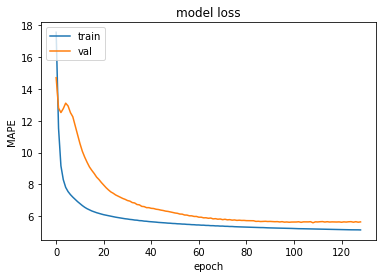

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('gru.jpeg')


MODEL LSTM

In [19]:
model_enc_LSTM = Sequential()
model_enc_LSTM.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
model_enc_LSTM.add(RepeatVector(n_steps_out))
model_enc_LSTM.add(LSTM(32, activation='relu', return_sequences=True))
model_enc_LSTM.add(TimeDistributed(Dense(2)))
model_enc_LSTM.summary()

cp_lstm = ModelCheckpoint('model_lstm', save_best_only=True, monitor='val_loss')
model_enc_LSTM.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))
history2 = model_enc_LSTM.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_lstm,EarlyStopping(monitor='val_loss', patience=20)])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                18688     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 20, 64)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 20, 32)            12416     
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 2)            66        
 tributed)                                                       
                                                                 
Total params: 31,170
Trainable params: 31,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4219/4219 [===========================

Epoch 34/200
4219/4219 [==============================] - 92s 22ms/step - loss: 5.6080 - val_loss: 7.6065
Epoch 35/200
4219/4219 [==============================] - 83s 20ms/step - loss: 5.5872 - val_loss: 7.6191
Epoch 36/200
4219/4219 [==============================] - 86s 20ms/step - loss: 5.5826 - val_loss: 7.5361
Epoch 37/200
4219/4219 [==============================] - 87s 21ms/step - loss: 5.5542 - val_loss: 7.5344
Epoch 38/200
4219/4219 [==============================] - 86s 20ms/step - loss: 5.5548 - val_loss: 7.4630
Epoch 39/200
4219/4219 [==============================] - 87s 21ms/step - loss: 5.5243 - val_loss: 7.4591
Epoch 40/200
4219/4219 [==============================] - 89s 21ms/step - loss: 5.5204 - val_loss: 7.3999
Epoch 41/200
4219/4219 [==============================] - 83s 20ms/step - loss: 5.4982 - val_loss: 7.4040
Epoch 42/200
4219/4219 [==============================] - 87s 21ms/step - loss: 5.4897 - val_loss: 7.2550
Epoch 43/200
4219/4219 [======================

Epoch 80/200
4219/4219 [==============================] - 84s 20ms/step - loss: 5.1914 - val_loss: 6.5107
Epoch 81/200
4219/4219 [==============================] - 87s 21ms/step - loss: 5.1918 - val_loss: 6.4646
Epoch 82/200
4219/4219 [==============================] - 88s 21ms/step - loss: 5.1878 - val_loss: 6.4690
Epoch 83/200
4219/4219 [==============================] - 88s 21ms/step - loss: 5.1809 - val_loss: 6.4572
Epoch 84/200
4219/4219 [==============================] - 91s 22ms/step - loss: 5.1785 - val_loss: 6.4223
Epoch 85/200
4219/4219 [==============================] - 86s 20ms/step - loss: 5.1745 - val_loss: 6.4588
Epoch 86/200
4219/4219 [==============================] - 89s 21ms/step - loss: 5.1692 - val_loss: 6.3824
Epoch 87/200
4219/4219 [==============================] - 86s 20ms/step - loss: 5.1638 - val_loss: 6.3876
Epoch 88/200
4219/4219 [==============================] - 90s 21ms/step - loss: 5.1574 - val_loss: 6.3805
Epoch 89/200
4219/4219 [======================

4219/4219 [==============================] - 87s 21ms/step - loss: 5.0080 - val_loss: 6.1559
Epoch 133/200
4219/4219 [==============================] - 92s 22ms/step - loss: 5.0015 - val_loss: 6.1068
Epoch 134/200
4219/4219 [==============================] - 86s 20ms/step - loss: 5.0020 - val_loss: 6.1713
Epoch 135/200
4219/4219 [==============================] - 85s 20ms/step - loss: 4.9953 - val_loss: 6.1175
Epoch 136/200
4219/4219 [==============================] - 89s 21ms/step - loss: 4.9957 - val_loss: 6.1592
Epoch 137/200
4219/4219 [==============================] - 88s 21ms/step - loss: 4.9922 - val_loss: 6.1251
Epoch 138/200
4219/4219 [==============================] - 90s 21ms/step - loss: 4.9899 - val_loss: 6.1631
Epoch 139/200
4219/4219 [==============================] - 86s 20ms/step - loss: 4.9878 - val_loss: 6.1301
Epoch 140/200
4219/4219 [==============================] - 87s 21ms/step - loss: 4.9840 - val_loss: 6.1295
Epoch 141/200
4219/4219 [==========================

Epoch 193/200
4219/4219 [==============================] - 79s 19ms/step - loss: 4.8724 - val_loss: 6.0227
Epoch 194/200
4219/4219 [==============================] - 81s 19ms/step - loss: 4.8651 - val_loss: 6.0177
Epoch 195/200
4219/4219 [==============================] - 79s 19ms/step - loss: 4.8659 - val_loss: 6.0257
Epoch 196/200
4219/4219 [==============================] - 82s 19ms/step - loss: 4.8602 - val_loss: 6.0035
Epoch 197/200
4219/4219 [==============================] - 78s 19ms/step - loss: 4.8624 - val_loss: 6.0282
Epoch 198/200
4219/4219 [==============================] - 79s 19ms/step - loss: 4.8573 - val_loss: 6.0069
Epoch 199/200
4219/4219 [==============================] - 79s 19ms/step - loss: 4.8585 - val_loss: 6.0176
Epoch 200/200
4219/4219 [==============================] - 82s 19ms/step - loss: 4.8546 - val_loss: 5.9933


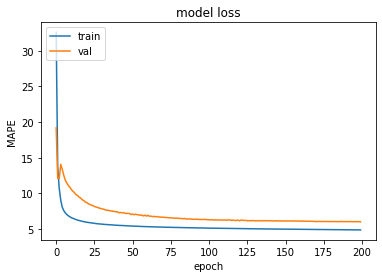

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('lstm.png')

MODEL BIDIRECTIONAL LSTM

In [19]:
model_enc_biLSTM = Sequential()
model_enc_biLSTM.add(Bidirectional(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features))))
model_enc_biLSTM.add(RepeatVector(n_steps_out))

model_enc_biLSTM.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_enc_biLSTM.add(TimeDistributed(Dense(2)))
model_enc_biLSTM.build(input_shape=(None,n_steps_in, n_features))
model_enc_biLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 128)              37376     
 nal)                                                            
                                                                 
 repeat_vector_2 (RepeatVect  (None, 20, 128)          0         
 or)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 64)           41216     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 2)            130       
 tributed)                                                       
                                                                 
Total params: 78,722
Trainable params: 78,722
Non-trai

In [20]:

cp_bilstm = ModelCheckpoint('model_bilstm', save_best_only=True, monitor='val_loss')
model_enc_biLSTM.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))
history3 = model_enc_biLSTM.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_bilstm,EarlyStopping(monitor='val_loss', patience=20)])


Epoch 1/200
4219/4219 [==============================] - 170s 39ms/step - loss: 31.0263 - val_loss: 16.6589
Epoch 2/200
4219/4219 [==============================] - 146s 34ms/step - loss: 13.5969 - val_loss: 13.4650
Epoch 3/200
4219/4219 [==============================] - 128s 30ms/step - loss: 10.9435 - val_loss: 15.4635
Epoch 4/200
4219/4219 [==============================] - 136s 32ms/step - loss: 9.1879 - val_loss: 15.7492
Epoch 5/200
4219/4219 [==============================] - 139s 33ms/step - loss: 8.3417 - val_loss: 15.3388
Epoch 6/200
4219/4219 [==============================] - 160s 38ms/step - loss: 7.7268 - val_loss: 14.5533
Epoch 7/200
4219/4219 [==============================] - 171s 40ms/step - loss: 7.3055 - val_loss: 13.7237
Epoch 8/200
4219/4219 [==============================] - 165s 39ms/step - loss: 7.0283 - val_loss: 12.9062
Epoch 9/200
4219/4219 [==============================] - 163s 39ms/step - loss: 6.7565 - val_loss: 12.0535
Epoch 10/200
4219/4219 [==========

4219/4219 [==============================] - 143s 34ms/step - loss: 5.3332 - val_loss: 7.3657
Epoch 46/200
4219/4219 [==============================] - 155s 37ms/step - loss: 5.3254 - val_loss: 7.1478
Epoch 47/200
4219/4219 [==============================] - 132s 31ms/step - loss: 5.3143 - val_loss: 7.2453
Epoch 48/200
4219/4219 [==============================] - 147s 35ms/step - loss: 5.3080 - val_loss: 6.9668
Epoch 49/200
4219/4219 [==============================] - 147s 35ms/step - loss: 5.2924 - val_loss: 6.9279
Epoch 50/200
4219/4219 [==============================] - 153s 36ms/step - loss: 5.2874 - val_loss: 7.0016
Epoch 51/200
4219/4219 [==============================] - 135s 32ms/step - loss: 5.2727 - val_loss: 6.9579
Epoch 52/200
4219/4219 [==============================] - 138s 33ms/step - loss: 5.2676 - val_loss: 6.9375
Epoch 53/200
4219/4219 [==============================] - 153s 36ms/step - loss: 5.2566 - val_loss: 6.8293
Epoch 54/200
4219/4219 [==========================

4219/4219 [==============================] - 182s 43ms/step - loss: 4.9782 - val_loss: 6.1706
Epoch 103/200
4219/4219 [==============================] - 170s 40ms/step - loss: 4.9653 - val_loss: 6.2724
Epoch 104/200
4219/4219 [==============================] - 183s 43ms/step - loss: 4.9686 - val_loss: 6.2324
Epoch 105/200
4219/4219 [==============================] - 173s 41ms/step - loss: 4.9609 - val_loss: 6.2492
Epoch 106/200
4219/4219 [==============================] - 149s 35ms/step - loss: 4.9572 - val_loss: 6.2352
Epoch 107/200
4219/4219 [==============================] - 150s 36ms/step - loss: 4.9458 - val_loss: 6.3185
Epoch 108/200
4219/4219 [==============================] - 160s 38ms/step - loss: 4.9472 - val_loss: 6.2651
Epoch 109/200
4219/4219 [==============================] - 158s 37ms/step - loss: 4.9461 - val_loss: 6.4001
Epoch 110/200
4219/4219 [==============================] - 166s 39ms/step - loss: 4.9371 - val_loss: 6.1342
Epoch 111/200
4219/4219 [=================

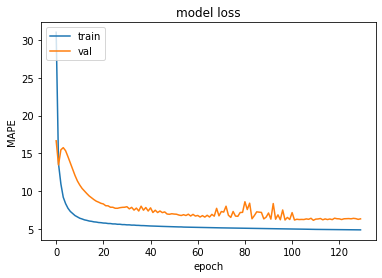

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('bilstm.png')

MODEL BIDIRECTIONAL GRU

In [16]:
model_enc_bigru = Sequential()
model_enc_bigru.add(Bidirectional(GRU(64, activation='relu', input_shape=(n_steps_in, n_features))))
model_enc_bigru.add(RepeatVector(n_steps_out))

model_enc_bigru.add(Bidirectional(GRU(32, activation='relu', return_sequences=True)))
model_enc_bigru.add(TimeDistributed(Dense(2)))
model_enc_bigru.build(input_shape=(None,n_steps_in, n_features))
model_enc_bigru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128)              28416     
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 20, 128)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 64)           31104     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 2)            130       
 tributed)                                                       
                                                                 
Total params: 59,650
Trainable params: 59,650
Non-trai

In [17]:

cp_bigru = ModelCheckpoint('model_bigru', save_best_only=True, monitor='val_loss')
model_enc_bigru.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))
history4 = model_enc_bigru.fit(X_train, y_train, batch_size = 32, shuffle=False, validation_data=(X_val, y_val), epochs=150, callbacks=[cp_bigru,EarlyStopping(monitor='val_loss', patience=50)])


Epoch 1/150
4219/4219 [==============================] - 124s 28ms/step - loss: 14.7421 - val_loss: 13.1841
Epoch 2/150
4219/4219 [==============================] - 122s 29ms/step - loss: 8.6969 - val_loss: 12.4812
Epoch 3/150
4219/4219 [==============================] - 121s 29ms/step - loss: 7.7353 - val_loss: 12.0791
Epoch 4/150
4219/4219 [==============================] - 120s 28ms/step - loss: 7.3484 - val_loss: 11.7066
Epoch 5/150
4219/4219 [==============================] - 123s 29ms/step - loss: 7.0889 - val_loss: 11.3456
Epoch 6/150
4219/4219 [==============================] - 123s 29ms/step - loss: 6.8841 - val_loss: 11.0389
Epoch 7/150
4219/4219 [==============================] - 120s 28ms/step - loss: 6.7158 - val_loss: 10.7105
Epoch 8/150
4219/4219 [==============================] - 118s 28ms/step - loss: 6.5674 - val_loss: 10.3210
Epoch 9/150
4219/4219 [==============================] - 117s 28ms/step - loss: 6.4505 - val_loss: 9.8910
Epoch 10/150
4219/4219 [=============

Epoch 37/150
4219/4219 [==============================] - 118s 28ms/step - loss: 5.4611 - val_loss: 6.8648
Epoch 38/150
4219/4219 [==============================] - 118s 28ms/step - loss: 5.4482 - val_loss: 6.8220
Epoch 39/150
4219/4219 [==============================] - 117s 28ms/step - loss: 5.4360 - val_loss: 6.7778
Epoch 40/150
4219/4219 [==============================] - 118s 28ms/step - loss: 5.4250 - val_loss: 6.7541
Epoch 41/150
4219/4219 [==============================] - 117s 28ms/step - loss: 5.4135 - val_loss: 6.7192
Epoch 42/150
4219/4219 [==============================] - 117s 28ms/step - loss: 5.4042 - val_loss: 6.6886
Epoch 43/150
4219/4219 [==============================] - 118s 28ms/step - loss: 5.3930 - val_loss: 6.6472
Epoch 44/150
4219/4219 [==============================] - 119s 28ms/step - loss: 5.3839 - val_loss: 6.6190
Epoch 45/150
4219/4219 [==============================] - 118s 28ms/step - loss: 5.3747 - val_loss: 6.5848
Epoch 46/150
4219/4219 [=============

Epoch 81/150
4219/4219 [==============================] - 112s 27ms/step - loss: 5.1494 - val_loss: 5.9774
Epoch 82/150
4219/4219 [==============================] - 125s 30ms/step - loss: 5.1422 - val_loss: 5.9317
Epoch 83/150
4219/4219 [==============================] - 114s 27ms/step - loss: 5.1403 - val_loss: 5.9655
Epoch 84/150
4219/4219 [==============================] - 124s 29ms/step - loss: 5.1373 - val_loss: 5.9166
Epoch 85/150
4219/4219 [==============================] - 115s 27ms/step - loss: 5.1343 - val_loss: 5.9344
Epoch 86/150
4219/4219 [==============================] - 117s 28ms/step - loss: 5.1281 - val_loss: 5.9261
Epoch 87/150
4219/4219 [==============================] - 117s 28ms/step - loss: 5.1234 - val_loss: 5.9236
Epoch 88/150
4219/4219 [==============================] - 126s 30ms/step - loss: 5.1204 - val_loss: 5.8900
Epoch 89/150
4219/4219 [==============================] - 114s 27ms/step - loss: 5.1154 - val_loss: 5.9029
Epoch 90/150
4219/4219 [=============

4219/4219 [==============================] - 149s 35ms/step - loss: 4.9471 - val_loss: 5.7025
Epoch 136/150
4219/4219 [==============================] - 165s 39ms/step - loss: 4.9508 - val_loss: 5.6959
Epoch 137/150
4219/4219 [==============================] - 140s 33ms/step - loss: 4.9489 - val_loss: 5.6871
Epoch 138/150
4219/4219 [==============================] - 199s 47ms/step - loss: 4.9433 - val_loss: 5.6813
Epoch 139/150
4219/4219 [==============================] - 162s 38ms/step - loss: 4.9375 - val_loss: 5.6900
Epoch 140/150
4219/4219 [==============================] - 177s 42ms/step - loss: 4.9304 - val_loss: 5.6857
Epoch 141/150
4219/4219 [==============================] - 177s 42ms/step - loss: 4.9302 - val_loss: 5.7097
Epoch 142/150
4219/4219 [==============================] - 152s 36ms/step - loss: 4.9266 - val_loss: 5.6909
Epoch 143/150
4219/4219 [==============================] - 180s 43ms/step - loss: 4.9244 - val_loss: 5.6695
Epoch 144/150
4219/4219 [=================

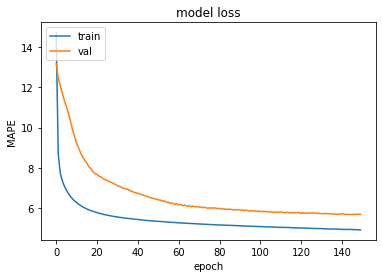

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('bigru.png')